In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 📊 Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.offline as pyo

# 🧠 Modelli e metriche
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy import stats

# 🧹 Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 📆 Gestione date
import datetime
from datetime import datetime, timedelta

# 🎨 Configurazione plot
sns.set_theme(context='notebook', style='whitegrid', palette='tab10')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

df_social_finale = pd.read_csv("src/output-data/social_data_con_nomi_reali.csv", encoding="utf-8")
merged_data = pd.read_csv('src/output-data/merged_data.csv')
df_election = pd.read_csv("datasets/Politiche2022_Scrutini_Camera_Italia.csv", encoding="utf-8")
social_data_mapped = df_social_finale.copy()



In [8]:
%%HTML
<link rel="stylesheet" type="text/css" href="style.css">

<p class="sub">166932 &mdash; Zahid Mehdi</p>
<h1><b>Analisi dell'impatto dell'attività TikTok sui risultati elettorali italiani del 2022</b></h1>
<p class="sub">10/07/2025 &mdash; Università degli Studi di Udine</p>

<div style="display: flex; justify-content: center; flex-wrap: wrap; font-family: Arial, sans-serif; color: #000; max-width: 1100px; margin: 40px auto;">
  <div style="flex: 1 1 500px; min-width: 300px; background:#FAFAFA; padding:20px; border-radius:12px; box-shadow:0 4px 10px rgba(0,0,0,0.08);">
    <h2 style="text-align:center; color:#2C2C2C;">Il progetto in breve</h2>
    <ul style="font-size: 16px; line-height: 1.8; margin-top: 20px;">
      <li><strong>Analisi TikTok</strong>: attività dei politici italiani durante le elezioni 2022</li>
      <li><strong>Mappatura avanzata</strong>: 74 politici mappati (username → nomi → partiti)</li>
      <li><strong>Dataset finale</strong>: 220 video con metriche complete di engagement</li>
      <li><strong>Modello predittivo</strong>: r = 0.833, p = 0.010 tra attività TikTok e voti</li>
      <li><strong>Risultato chiave</strong>: 70.3% della varianza nei voti spiegata</li>
    </ul>
    <p style="margin-top:18px; font-size:12px; text-align:center; color:gray;">
      <i>Data Science Project - Mehdi Zahid - UNIUD 2025</i>
    </p>
  </div>
</div>
<div style="display: flex; justify-content: center; gap: 40px; flex-wrap: wrap; margin: 20px auto; font-family: Arial, sans-serif; max-width: 1100px;">
  <img src="src/img/2022-speciale-elezioni-politiche.png" alt="Elezioni" style="width: 220px; height: auto; border-radius: 10px; box-shadow: 0 4px 10px rgba(0,0,0,0.1);">
  <img src="src/img/tiktok-logo.png" alt="TikTok" style="width: 80px; height: auto; border-radius: 10px; box-shadow: 0 4px 10px rgba(0,0,0,0.1);">
</div>

<div style="display: flex; justify-content: center; flex-wrap: wrap; font-family: Arial, sans-serif; color: #000; max-width: 1100px; margin: 40px auto;">
  <div style="flex: 1 1 800px; background:#FAFAFA; padding:20px; border-radius:12px; box-shadow:0 4px 10px rgba(0,0,0,0.08);">
    <h2 style="text-align:center; color:#2C2C2C;">Ispirazione e metriche analizzate</h2>
    <p style="font-size: 16px; line-height: 1.6;">
      Questo progetto analizza l'engagement dei politici italiani su TikTok durante le elezioni politiche del 2022. 
      L'obiettivo è valutare il potenziale predittivo delle metriche social rispetto ai risultati elettorali ufficiali.
    </p>
  </div>
</div>

<div style="max-width: 600px; margin: 0 auto 40px auto; font-family: Arial, sans-serif; color: #000; background:#FAFAFA; padding:20px; border-radius:12px; box-shadow:0 4px 10px rgba(0,0,0,0.08);">

  <h3 style="margin-top: 0; color:#2C2C2C;">Ispirazione</h3>
  <p style="font-size: 15px; line-height: 1.6;">
    Lo studio è stato ispirato da casi reali di <strong>microtargeting politico tramite social media</strong>, in particolare lo <i>scandalo Cambridge Analytica</i> durante la campagna di <strong>Donald Trump (2016)</strong>. 
    L'obiettivo era indagare se anche in Italia esistano segnali di relazione tra <strong>attività social</strong> e <strong>performance elettorale</strong>.
  </p>
</div>

<div style="max-width: 600px; margin: 0 auto 40px auto; font-family: Arial, sans-serif; color: #000; background:#FAFAFA; padding:20px; border-radius:12px; box-shadow:0 4px 10px rgba(0,0,0,0.08);">

  <h3 style="margin-top: 0; color:#2C2C2C;">Metriche TikTok analizzate</h3>
  <ul style="line-height: 1.8; font-size: 16px;">
    <li>Numero di post</li>
    <li>Visualizzazioni totali</li>
    <li>Likes ricevuti</li>
    <li>Commenti generati</li>
    <li>Condivisioni ottenute</li>
  </ul>

</div>

<div style="max-width: 1000px; margin: 0 auto 40px auto; font-family: Arial, sans-serif; color: #000; background: #FAFAFA; padding: 24px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.08);">
  <h2 style="margin-top: 0; color:#2C2C2C;"> Origine dei Dati Utilizzati</h2>
  <div style="margin-bottom: 30px;">
    <h3 style="color:#2C2C2C;"> Dati TikTok & Attività Social</h3>
    <ul style="line-height: 1.8; font-size: 16px;">
      <li>Basati sul dataset <strong>ITA-ELECTION-2022</strong>: raccolta multi-piattaforma di conversazioni social sulle elezioni italiane 2022</li>
      <li>Fonte: <a href="https://github.com/frapierri/ita-election-2022" target="_blank">github.com/frapierri/ita-election-2022</a></li>
      <li>Riferimento accademico: Pierri et al. (CIKM 2023), DOI: <a href="https://doi.org/10.1145/3583780.3615121" target="_blank">10.1145/3583780.3615121</a></li>
      <li>Metadati TikTok raccolti tramite scraping e annotazioni manuali, in particolare: <code>Facebook_Tiktok_metadata.csv</code></li>
    </ul>
  </div>
  <div>
    <h3 style="color:#2C2C2C;"> Dati Elettorali Ufficiali</h3>
    <ul style="line-height: 1.8; font-size: 16px;">
      <li>Risultati delle <strong>Elezioni Politiche 2022</strong> per la Camera dei Deputati</li>
      <li>Dati pubblicati da <a href="https://elezioni.interno.gov.it" target="_blank">Eligendo – Ministero dell’Interno</a></li>
      <li>Rielaborati e messi a disposizione dal progetto <a href="https://ondata.it" target="_blank">onData</a></li>
      <li>Dataset: <a href="https://github.com/ondata/elezioni-politiche-2022/blob/main/affluenza-risultati/dati/Eligendo/processing/Politiche2022_Scrutini_Camera_Italia.csv" target="_blank">Politiche2022_Scrutini_Camera_Italia.csv</a></li>
    </ul>
    <p style="font-size: 14px; color: gray;">
       Per correttezza: “Dati elettorali da un progetto di <a href='https://github.com/ondata/elezioni-politiche-2022' target='_blank'>onData</a>”
    </p>
  </div>
</div>

<div style="max-width: 700px; margin: 40px auto; background: #FAFAFA; padding: 25px 30px; border-radius: 12px; box-shadow: 0 4px 10px rgba(0,0,0,0.08); font-family: Arial, sans-serif; color: #000;">
  <h2 style="text-align: center; color: #2C2C2C; margin-top: 0;"><b>Cosa vorrei scoprire?</b></h2>
  <ol style="font-size: 16px; line-height: 1.8; padding-left: 20px;">
    <li>Come si distribuiscono le metriche TikTok durante le elezioni politiche italiane</li>
    <li>Chi sono i <strong>Top Performer</strong> su TikTok tra i politici</li>
    <li>Quale metrica TikTok è <strong>più predittiva dei voti</strong> reali</li>
    <li>Se è possibile <strong>prevedere in anticipo</strong> il risultato elettorale usando TikTok</li>
  </ol>
  <p style="margin-top: 20px; text-align: center; font-size: 12px; color: gray;">
    <i>Domande guida del progetto</i>
  </p>
</div>

<div style="display: flex; gap: 30px; justify-content: center; flex-wrap: wrap; align-items: flex-start; font-family: Arial, sans-serif; color: #000; max-width: 1100px; margin: 40px auto;">

  <!-- SINISTRA: Blocco tabellare -->
  <div style="flex: 1 1 500px; min-width: 300px; background:#FAFAFA; padding:20px; border-radius:12px; box-shadow:0 4px 10px rgba(0,0,0,0.08);">
    <h2 style="text-align:center; color:#2C2C2C;">Filtraggio Dataset TikTok Elections 2022</h2>
    <table style="width:100%; border-collapse:collapse; font-size:16px; margin-top:20px;">
      <thead>
        <tr style="background:#F0F0F0;">
          <th style="padding:10px; text-align:left;">Categoria</th>
          <th style="padding:10px; text-align:right;">Valore</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td style="padding:10px;">Video Totali Analizzati</td>
          <td style="padding:10px; text-align:right;">1,744</td>
        </tr>
        <tr>
          <td style="padding:10px;">Video Utilizzabili (Finale)</td>
          <td style="padding:10px; text-align:right; color:#00C853;"><strong>220</strong> (12.6%)</td>
        </tr>
        <tr>
          <td style="padding:10px;">Video Scartati (Fuzzy Matching)</td>
          <td style="padding:10px; text-align:right; color:#FF0050;">1,524 (87.4%)</td>
        </tr>
        <tr style="background:#F8F8F8;">
          <td style="padding:10px;"><strong>Efficienza Pipeline</strong></td>
          <td style="padding:10px; text-align:right;"><strong>12.6%</strong></td>
        </tr>
      </tbody>
    </table>
    <p style="margin-top:20px; font-size:12px; text-align:center; color:gray;">
      <i>Pipeline di Fuzzy Matching → Politici riconosciuti correttamente</i><br>
    </p>
  </div>
</div>

<h2 style="text-align:center; color:#2C2C2C;">Filtraggio Dataset TikTok Elections 2022</h2>
<div style="display: flex; justify-content: center; font-family: Arial, sans-serif; color: #000; margin-top: 20px;">
  <div style="flex: 1 1 400px; min-width: 300px; background: #FAFAFA; padding: 20px; border-radius: 12px; box-shadow: 0 4px 10px rgba(0,0,0,0.08);">
    <h3 style="margin-top: 0; color:#2C2C2C;">Perché il dataset finale è così ridotto?</h3>
    <p>La <strong>maggior parte dei video (87.4%)</strong> non hanno match validi, dovuta a:</p>
    <ul style="padding-left: 20px; line-height: 1.6;">
      <li>Username TikTok spesso diversi dai nomi reali</li>
      <li>Presenza di account non verificati</li>
      <li>Politici non presenti nel database elettorale</li>
      <li>Variazioni nella scrittura dei nomi</li>
    </ul>
       <p style="margin-top:20px; font-size:12px; text-align:center; color:gray;">
      <i>Pipeline di Fuzzy Matching → Politici riconosciuti correttamente</i><br>
    </p>
  </div>
</div>

<div style="max-width: 800px; margin: 40px auto; background: #FAFAFA; padding: 25px 30px; border-radius: 12px; box-shadow: 0 4px 10px rgba(0,0,0,0.08); font-family: Arial, sans-serif; color: #000;">
  <h2 style="text-align: center; color: #2C2C2C;"><b>1) Come sono distribuite le variabili TikTok ed elettorali?</b></h2>
  <p style="font-size: 16px; line-height: 1.6;">
    Analisi delle <strong>curve di densità (KDE)</strong> per comprendere la forma e la simmetria delle principali variabili quantitative:
  </p>
  <ul style="font-size: 16px; line-height: 1.8; padding-left: 20px; margin-top: 10px;">
    <li><strong>Totale voti</strong> ricevuti da ciascun partito</li>
    <li><strong>Numero di post TikTok</strong> pubblicati dai partiti</li>
    <li><strong>Visualizzazioni totali</strong> su TikTok <i>(in scala logaritmica)</i></li>
    <li><strong>Engagement complessivo</strong>: somma di like, commenti e condivisioni <i>(in scala logaritmica)</i></li>
  </ul>
  <p style="margin-top: 20px; text-align: center; font-size: 12px; color: gray;">
    <i>Distribuzioni KDE per identificare skew, outlier e tendenze</i>
  </p>
</div>

<h3><b>1) Come sono distribuite le variabili TikTok ed elettorali?</b></h3>
<h4 class="sub"><b>Le 4 curve di densità (KDE)</b></h4>

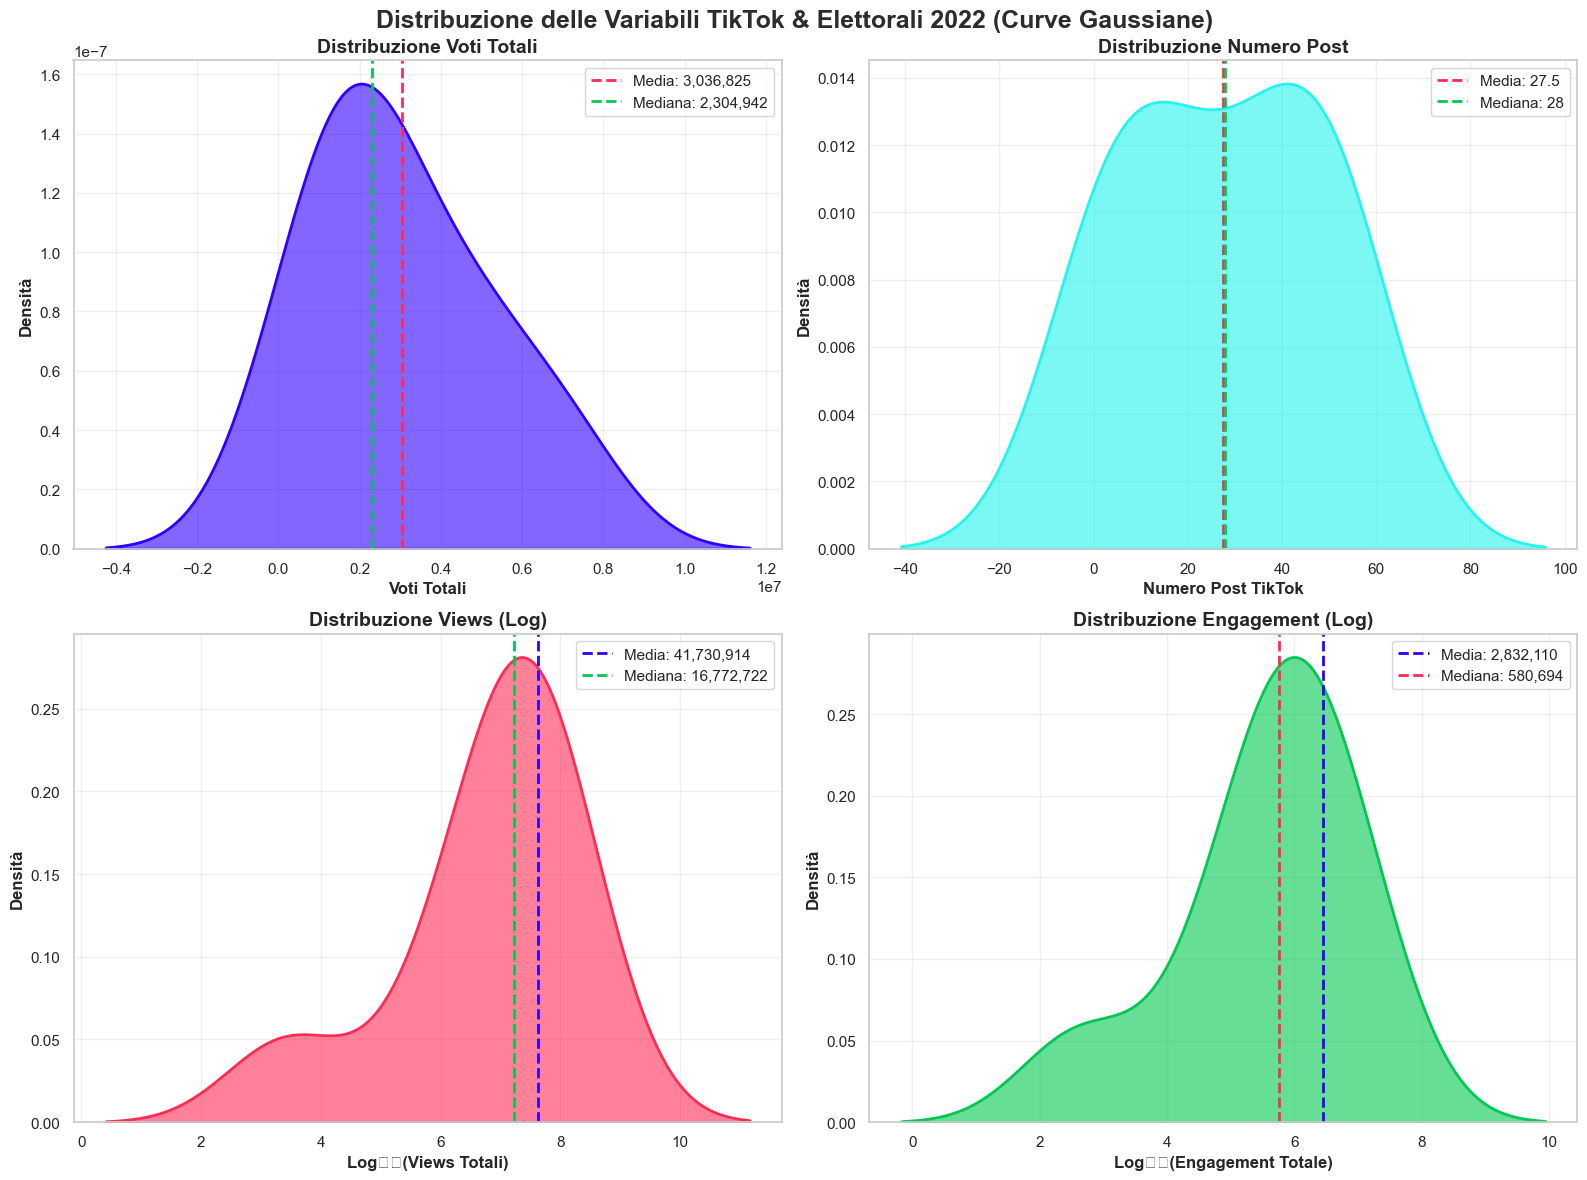

In [9]:
# 📊 DISTRIBUZIONE DELLE VARIABILI PRINCIPALI (KDE - CURVE GAUSSIANE)
COLORS_PIE = {
    'primary': "#2F00FF",   
    'secondary': '#25F4EE',  
    'accent': '#FE2C55',     
    'dark': '#2C2C2C',
    'red': '#FF0050',
    'success': '#00C851',
}
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribuzione delle Variabili TikTok & Elettorali 2022 (Curve Gaussiane)', 
             fontsize=18, fontweight='bold', color=COLORS_PIE['dark'])

# === SUBPLOT 1: DISTRIBUZIONE VOTI (KDE) ===
ax1 = axes[0, 0]
sns.kdeplot(data=merged_data, x='TOTALE_VOTI_LISTA', ax=ax1, 
            color=COLORS_PIE['primary'], fill=True, alpha=0.6, linewidth=2)
ax1.axvline(merged_data['TOTALE_VOTI_LISTA'].mean(), color=COLORS_PIE['accent'], 
           linestyle='--', linewidth=2, label=f'Media: {merged_data["TOTALE_VOTI_LISTA"].mean():,.0f}')
ax1.axvline(merged_data['TOTALE_VOTI_LISTA'].median(), color=COLORS_PIE['success'], 
           linestyle='--', linewidth=2, label=f'Mediana: {merged_data["TOTALE_VOTI_LISTA"].median():,.0f}')
ax1.set_title('Distribuzione Voti Totali', fontsize=14, fontweight='bold')
ax1.set_xlabel('Voti Totali', fontweight='bold')
ax1.set_ylabel('Densità', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# === SUBPLOT 2: DISTRIBUZIONE POST TIKTOK (KDE) ===
ax2 = axes[0, 1]
sns.kdeplot(data=merged_data, x='NUMERO_POST_TIKTOK', ax=ax2, 
            color=COLORS_PIE['secondary'], fill=True, alpha=0.6, linewidth=2)
ax2.axvline(merged_data['NUMERO_POST_TIKTOK'].mean(), color=COLORS_PIE['accent'], 
           linestyle='--', linewidth=2, label=f'Media: {merged_data["NUMERO_POST_TIKTOK"].mean():.1f}')
ax2.axvline(merged_data['NUMERO_POST_TIKTOK'].median(), color=COLORS_PIE['success'], 
           linestyle='--', linewidth=2, label=f'Mediana: {merged_data["NUMERO_POST_TIKTOK"].median():.0f}')
ax2.set_title('Distribuzione Numero Post', fontsize=14, fontweight='bold')
ax2.set_xlabel('Numero Post TikTok', fontweight='bold')
ax2.set_ylabel('Densità', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# === SUBPLOT 3: DISTRIBUZIONE VIEWS LOG (KDE) ===
ax3 = axes[1, 0]
views_data = merged_data['TOTALE_VIEWS_TIKTOK'][merged_data['TOTALE_VIEWS_TIKTOK'] > 0]
log_views = np.log10(views_data)
sns.kdeplot(x=log_views, ax=ax3, 
            color=COLORS_PIE['accent'], fill=True, alpha=0.6, linewidth=2)
ax3.axvline(np.log10(views_data.mean()), color=COLORS_PIE['primary'], 
           linestyle='--', linewidth=2, label=f'Media: {views_data.mean():,.0f}')
ax3.axvline(np.log10(views_data.median()), color=COLORS_PIE['success'], 
           linestyle='--', linewidth=2, label=f'Mediana: {views_data.median():,.0f}')
ax3.set_title('Distribuzione Views (Log)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Log₁₀(Views Totali)', fontweight='bold')
ax3.set_ylabel('Densità', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# === SUBPLOT 4: DISTRIBUZIONE ENGAGEMENT LOG (KDE) ===
ax4 = axes[1, 1]
engagement_data = merged_data['ENGAGEMENT_TOTALE'][merged_data['ENGAGEMENT_TOTALE'] > 0]
log_engagement = np.log10(engagement_data)
sns.kdeplot(x=log_engagement, ax=ax4, 
            color=COLORS_PIE['success'], fill=True, alpha=0.6, linewidth=2)
ax4.axvline(np.log10(engagement_data.mean()), color=COLORS_PIE['primary'], 
           linestyle='--', linewidth=2, label=f'Media: {engagement_data.mean():,.0f}')
ax4.axvline(np.log10(engagement_data.median()), color=COLORS_PIE['accent'], 
           linestyle='--', linewidth=2, label=f'Mediana: {engagement_data.median():,.0f}')
ax4.set_title('Distribuzione Engagement (Log)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Log₁₀(Engagement Totale)', fontweight='bold')
ax4.set_ylabel('Densità', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<div style="max-width: 900px; margin: 40px auto; background: #FAFAFA; padding: 25px 30px; border-radius: 12px; box-shadow: 0 4px 10px rgba(0,0,0,0.08); font-family: Arial, sans-serif; color: #000;">
  <h2 style="text-align: center; color: #2C2C2C;"><b>2) Top Performer TikTok Elections 2022</b></h2>
  <p style="font-size: 16px; line-height: 1.8;">
    Analisi delle performance su quattro metriche chiave per identificare i partiti più efficaci su TikTok:
  </p>
  <ul style="line-height: 1.8; font-size: 16px; padding-left: 20px;">
    <li><strong>Numero di Post TikTok:</strong> chi ha pubblicato di più</li>
    <li><strong>Visualizzazioni Totali:</strong> chi ha generato più attenzione</li>
    <li><strong>Engagement Totale:</strong> chi ha stimolato più interazioni (like, commenti, condivisioni)</li>
    <li><strong>Voti Elettorali:</strong> chi ha convertito meglio la visibilità in consenso</li>
  </ul>
  <p style="margin-top: 20px; font-size: 16px;">
    Per ogni metrica viene mostrata la <strong>top 8 dei partiti</strong> più performanti. Il formato abbreviato (<code>K</code>, <code>M</code>) facilita la lettura dei volumi.
  </p>

</div>

<h3><b>2) Top Performer TikTok Elections 2022?</b></h3>


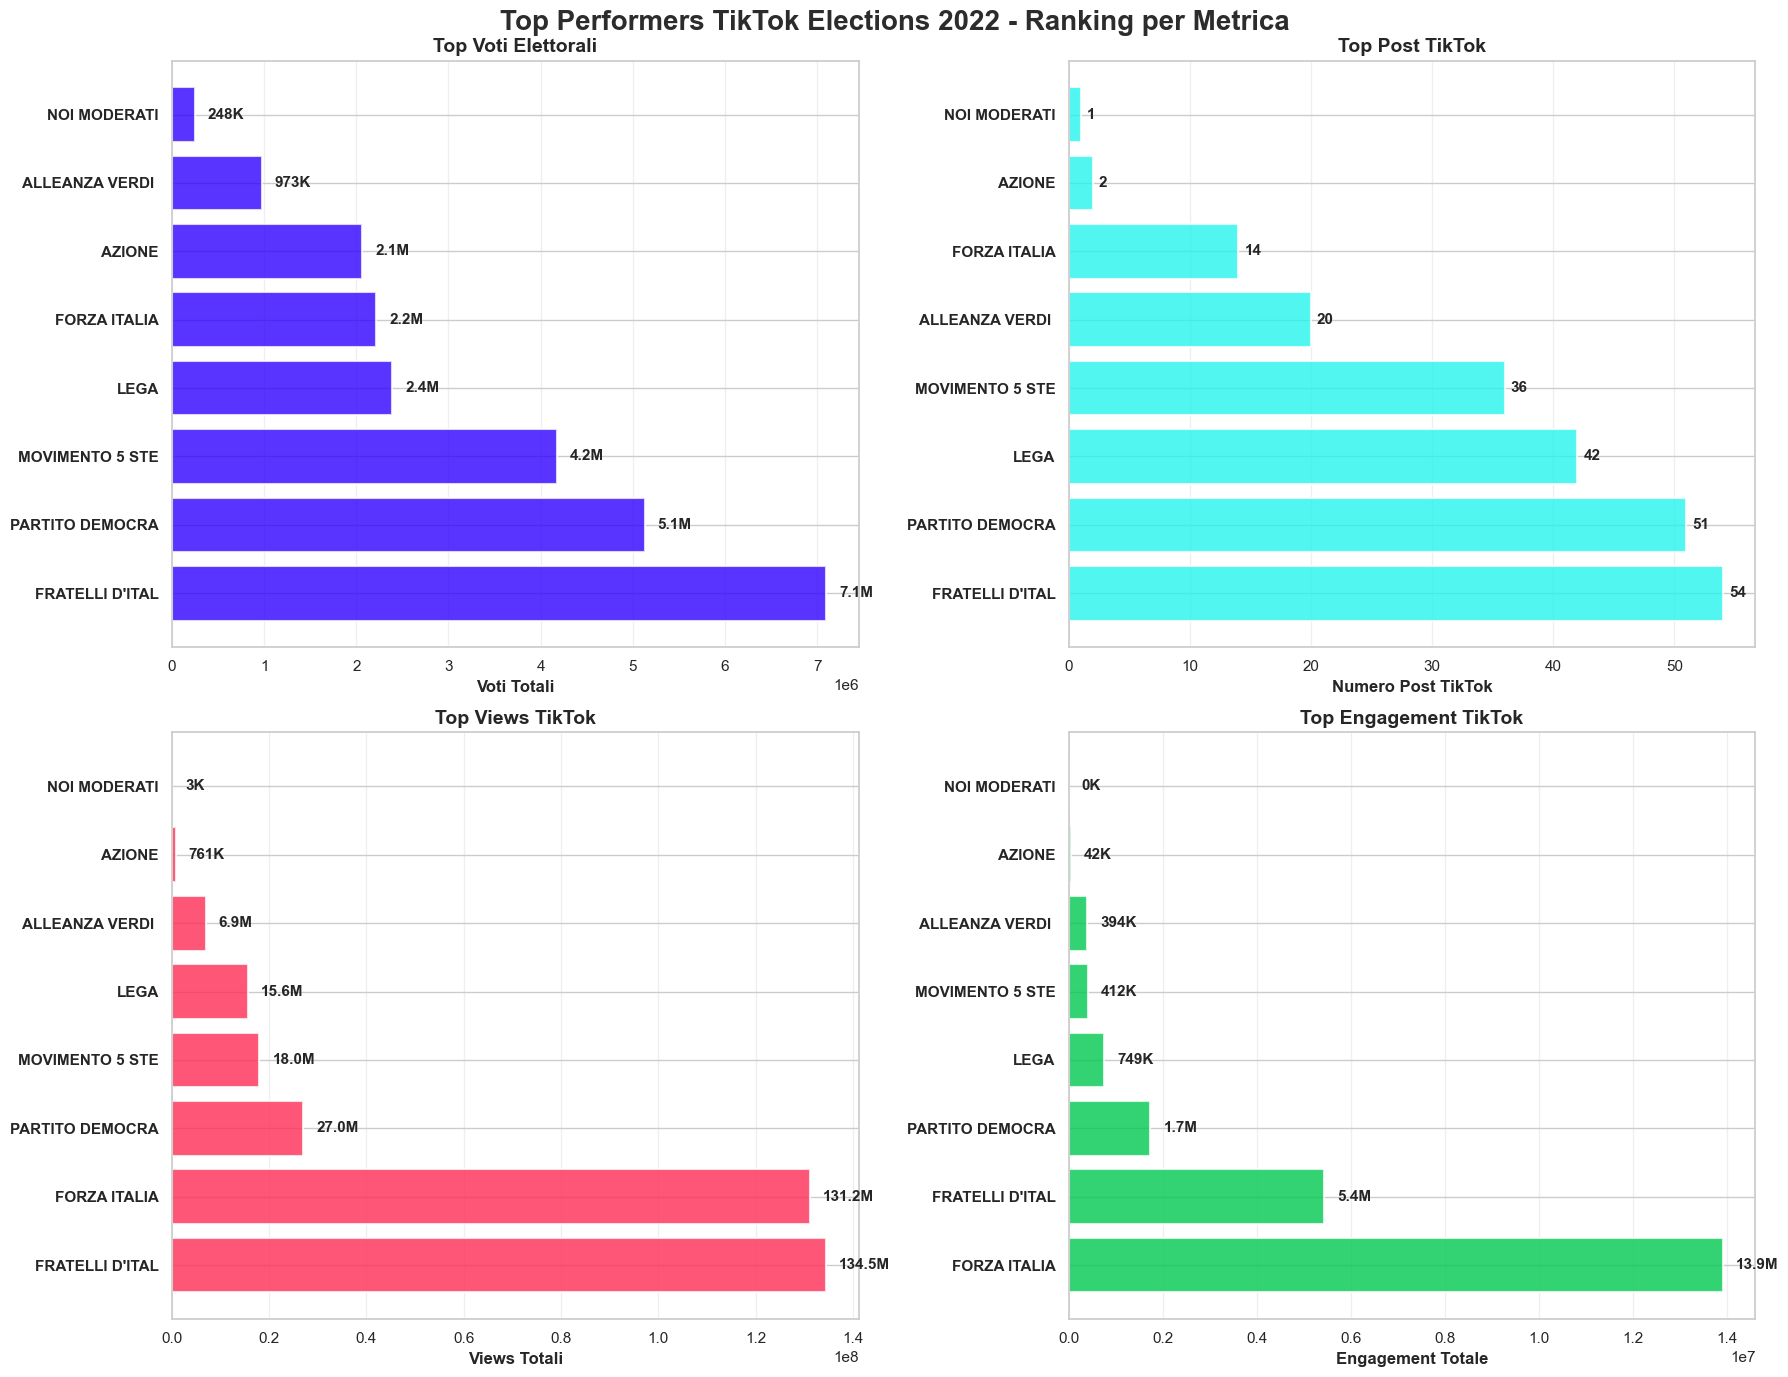

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Top Performers TikTok Elections 2022 - Ranking per Metrica', 
             fontsize=20, fontweight='bold', color=COLORS_PIE['dark'])

# Ordino i dati
top_voti = merged_data.nlargest(8, 'TOTALE_VOTI_LISTA')
top_posts = merged_data.nlargest(8, 'NUMERO_POST_TIKTOK')
top_views = merged_data.nlargest(8, 'TOTALE_VIEWS_TIKTOK')
top_engagement = merged_data.nlargest(8, 'ENGAGEMENT_TOTALE')

# === ALTO SINISTRA: VOTI ELETTORALI ===
ax1 = axes[0, 0]
bars1 = ax1.barh(range(len(top_voti)), top_voti['TOTALE_VOTI_LISTA'], 
                 color=COLORS_PIE['primary'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax1.set_yticks(range(len(top_voti)))
ax1.set_yticklabels([partito[:15] for partito in top_voti['PARTITO']], fontweight='bold')
ax1.set_xlabel('Voti Totali', fontweight='bold', fontsize=12)
ax1.set_title('Top Voti Elettorali', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, value) in enumerate(zip(bars1, top_voti['TOTALE_VOTI_LISTA'])):
    text = f'{value/1e6:.1f}M' if value > 1e6 else f'{value/1e3:.0f}K'
    ax1.text(value + max(top_voti['TOTALE_VOTI_LISTA']) * 0.02, i, text, va='center', fontweight='bold', fontsize=11)

# === ALTO DESTRA: NUMERO POST ===
ax2 = axes[0, 1]
bars2 = ax2.barh(range(len(top_posts)), top_posts['NUMERO_POST_TIKTOK'], 
                 color=COLORS_PIE['secondary'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax2.set_yticks(range(len(top_posts)))
ax2.set_yticklabels([partito[:15] for partito in top_posts['PARTITO']], fontweight='bold')
ax2.set_xlabel('Numero Post TikTok', fontweight='bold', fontsize=12)
ax2.set_title('Top Post TikTok', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for i, (bar, value) in enumerate(zip(bars2, top_posts['NUMERO_POST_TIKTOK'])):
    ax2.text(value + 0.5, i, f'{int(value)}', va='center', fontweight='bold', fontsize=11)

# === BASSO SINISTRA: VIEWS ===
ax3 = axes[1, 0]
bars3 = ax3.barh(range(len(top_views)), top_views['TOTALE_VIEWS_TIKTOK'], 
                 color=COLORS_PIE['accent'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax3.set_yticks(range(len(top_views)))
ax3.set_yticklabels([partito[:15] for partito in top_views['PARTITO']], fontweight='bold')
ax3.set_xlabel('Views Totali', fontweight='bold', fontsize=12)
ax3.set_title('Top Views TikTok', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
for i, (bar, value) in enumerate(zip(bars3, top_views['TOTALE_VIEWS_TIKTOK'])):
    text = f'{value/1e6:.1f}M' if value > 1e6 else f'{value/1e3:.0f}K'
    ax3.text(value + max(top_views['TOTALE_VIEWS_TIKTOK']) * 0.02, i, text, va='center', fontweight='bold', fontsize=11)

# === BASSO DESTRA: ENGAGEMENT ===
ax4 = axes[1, 1]
bars4 = ax4.barh(range(len(top_engagement)), top_engagement['ENGAGEMENT_TOTALE'], 
                 color=COLORS_PIE['success'], alpha=0.8, edgecolor='white', linewidth=1.5)
ax4.set_yticks(range(len(top_engagement)))
ax4.set_yticklabels([partito[:15] for partito in top_engagement['PARTITO']], fontweight='bold')
ax4.set_xlabel('Engagement Totale', fontweight='bold', fontsize=12)
ax4.set_title('Top Engagement TikTok', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
for i, (bar, value) in enumerate(zip(bars4, top_engagement['ENGAGEMENT_TOTALE'])):
    text = f'{value/1e6:.1f}M' if value > 1e6 else f'{value/1e3:.0f}K'
    ax4.text(value + max(top_engagement['ENGAGEMENT_TOTALE']) * 0.02, i, text, va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

<div style="max-width: 900px; margin: 40px auto; background: #FAFAFA; padding: 25px 30px; border-radius: 12px; box-shadow: 0 4px 10px rgba(0,0,0,0.08); font-family: Arial, sans-serif; color: #000;">
  <h2 style="text-align: center; color: #2C2C2C;"><b>3) Quale metrica TikTok è più predittiva dei voti?</b></h2>
  <p style="font-size: 16px; line-height: 1.8;">Come arrivare al risultato:</p>
  <ul style="line-height: 1.8; font-size: 16px; padding-left: 20px;">
    <li>Confronto delle <strong>correlazioni</strong> tra ciascuna metrica TikTok e i voti ricevuti</li>
    <li>Utilizzo di tre metodi: <strong>Pearson</strong>, <strong>Spearman</strong> e <strong>Kendall</strong></li>
    <li>Verifica della <strong>significatività statistica</strong> tramite i p-value</li>
    <li>Identificazione della metrica con il <strong>r più alto</strong> e <strong>p &lt; 0.05</strong></li>
  </ul>

</div>

In [11]:


# Definisco le variabili TikTok da analizzare
tiktok_variables = [
    'NUMERO_POST_TIKTOK',
    'TOTALE_VIEWS_TIKTOK', 
    'ENGAGEMENT_TOTALE',
    'TOTALE_LIKES_TIKTOK',
    'TOTALE_COMMENTI_TIKTOK',
    'TOTALE_SHARES_TIKTOK'
]

# Calcolo correlazioni con tutti e 3 i metodi
correlations_multimetodo = []
for var in tiktok_variables:
    if var in merged_data.columns:
        # Filtro valori validi (non zero)
        valid_data = merged_data[(merged_data[var] > 0) & (merged_data['TOTALE_VOTI_LISTA'] > 0)]
        
        if len(valid_data) > 2:  # Controllo dati sufficienti
            # Pearson (lineare)
            corr_pearson, p_pearson = pearsonr(valid_data[var], valid_data['TOTALE_VOTI_LISTA'])
            
            # Spearman (monotonica)
            corr_spearman, p_spearman = spearmanr(valid_data[var], valid_data['TOTALE_VOTI_LISTA'])
            
            # Kendall (non-parametrica)
            corr_kendall, p_kendall = kendalltau(valid_data[var], valid_data['TOTALE_VOTI_LISTA'])
            
            # Calcolo significatività media
            p_mean = np.mean([p_pearson, p_spearman, p_kendall])
            
            # Classificazione significatività
            if p_mean < 0.001:
                significance = "***"
                sig_level = "Altamente Significativa"
            elif p_mean < 0.01:
                significance = "**"
                sig_level = "Molto Significativa"
            elif p_mean < 0.05:
                significance = "*"
                sig_level = "Significativa"
            else:
                significance = ""
                sig_level = "Non Significativa"
            
            correlations_multimetodo.append({
                'variable': var,
                'pearson': corr_pearson,
                'spearman': corr_spearman,
                'kendall': corr_kendall,
                'p_pearson': p_pearson,
                'p_spearman': p_spearman,
                'p_kendall': p_kendall,
                'p_mean': p_mean,
                'significance': significance,
                'sig_level': sig_level,
                'n_samples': len(valid_data)
            })

# Converto in DataFrame
corr_multi_df = pd.DataFrame(correlations_multimetodo)

# Preparo nomi variabili puliti
var_names_clean = []
for var in corr_multi_df['variable']:
    if 'POST' in var:
        name = 'Numero Post'
    elif 'VIEWS' in var:
        name = 'Views Totali'
    elif 'ENGAGEMENT' in var:
        name = 'Engagement'
    elif 'LIKES' in var:
        name = 'Likes Totali'
    elif 'COMMENTI' in var:
        name = 'Commenti'
    elif 'SHARES' in var:
        name = 'Shares'
    else:
        name = var.replace('TOTALE_', '').replace('_TIKTOK', '')
    var_names_clean.append(name)

# === ANALISI STATISTICHE DETTAGLIATE ===
print("🔗 ANALISI CORRELAZIONI MULTIMETODO")
print("=" * 100)
print(f"{'Variabile':<15} {'Pearson':<10} {'Spearman':<10} {'Kendall':<10} {'P-Pearson':<10} {'P-Spearman':<10} {'P-Kendall':<10} {'Significatività':<15}")
print("-" * 100)

for i, (_, row) in enumerate(corr_multi_df.iterrows()):
    var_name = var_names_clean[i][:13]
    print(f"{var_name:<15} {row['pearson']:>8.3f}  {row['spearman']:>8.3f}  {row['kendall']:>8.3f}  "
          f"{row['p_pearson']:>8.3f}  {row['p_spearman']:>8.3f}  {row['p_kendall']:>8.3f}  {row['sig_level']:<15}")

# 

🔗 ANALISI CORRELAZIONI MULTIMETODO
Variabile       Pearson    Spearman   Kendall    P-Pearson  P-Spearman P-Kendall  Significatività
----------------------------------------------------------------------------------------------------
Numero Post        0.839     0.905     0.786     0.009     0.002     0.006  Molto Significativa
Views Totali       0.541     0.833     0.714     0.166     0.010     0.014  Non Significativa
Engagement         0.174     0.714     0.571     0.680     0.047     0.061  Non Significativa


<h2><b>3) Quale metrica TikTok è più predittiva dei voti?</b></h2>
<h4 class="sub"><b>Coefficienti di correlazione</b></h4>

<div style="display: flex; justify-content: center; font-family: Arial, sans-serif; color: #000; max-width: 1100px; margin: 0 auto;">
  <div style="flex: 1 1 550px; min-width: 320px; background:#FAFAFA; padding:20px; border-radius:12px; box-shadow:0 4px 10px rgba(0,0,0,0.08); overflow-x: auto;">
    <h2 style="text-align:center; color:#2C2C2C;">Analisi Correlazioni Multimetodo</h2>
    <table style="width:100%; border-collapse:collapse; font-size:15px; margin-top:20px; min-width: 500px;">
      <thead>
        <tr style="background:#F0F0F0;">
          <th style="padding:8px;">Variabile</th>
          <th style="padding:8px;">Pearson</th>
          <th style="padding:8px;">Spearman</th>
          <th style="padding:8px;">Kendall</th>
          <th style="padding:8px;">P-Pearson</th>
          <th style="padding:8px;">P-Spearman</th>
          <th style="padding:8px;">P-Kendall</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td style="padding:8px;">Numero Post</td>
          <td>0.839</td><td>0.905</td><td>0.786</td>
          <td>0.009</td><td>0.002</td><td>0.006</td>
        </tr>
        <tr>
          <td style="padding:8px;">Views Totali</td>
          <td>0.541</td><td>0.833</td><td>0.714</td>
          <td>0.166</td><td>0.010</td><td>0.014</td>
        </tr>
        <tr>
          <td style="padding:8px;">Engagement Totale</td>
          <td>0.174</td><td>0.714</td><td>0.571</td>
          <td>0.680</td><td>0.047</td><td>0.061</td>
        </tr>
      </tbody>
    </table>
    <p style="margin-top:18px; font-size:12px; text-align:center; color:gray;">
      Confronto tra coefficienti di correlazione per ogni metrica TikTok<br>
    </p>
  </div>
</div>

<h2><b>3) Quale metrica TikTok è più predittiva dei voti?</b></h2>
<h4 class="sub"><b>Coefficienti di correlazione</b></h4>
<div style="display: flex; justify-content: center; font-family: Arial, sans-serif; color: #000; margin-top: 20px;">
  <div style="flex: 1 1 400px; min-width: 300px; background: #FAFAFA; padding: 20px; border-radius: 12px; box-shadow: 0 4px 10px rgba(0,0,0,0.08);">
    <h3 style="margin-top: 0; color:#2C2C2C;">Quale metrica TikTok è più predittiva dei voti?</h3>
    <p>Tra tutte le metriche analizzate, il <strong>numero di post TikTok</strong> mostra:</p>
    <ul style="padding-left: 20px; line-height: 1.6;">
      <li>La <strong>correlazione più elevata</strong> con i voti</li>
      <li>Valori <strong>significativi per tutti i test</strong> (p &lt; 0.01)</li>
    </ul>
    <p style="margin-top:10px;">
       Views ed Engagement mostrano buoni valori ma con 
      <span style="color: #FF0050; font-weight: bold;">significatività più debole</span>.
    </p>
      <p style="margin-top:18px; font-size:12px; text-align:center; color:gray;">
      Confronto tra coefficienti di correlazione per ogni metrica TikTok<br>
    </p>
  </div>
</div>

<div style="max-width: 900px; margin: 40px auto; background: #FAFAFA; padding: 25px 30px; border-radius: 12px; box-shadow: 0 4px 10px rgba(0,0,0,0.08); font-family: Arial, sans-serif; color: #000;">
  <h2 style="text-align: center; color: #2C2C2C;"><b>4) È possibile scoprire in anticipo il risultato elettorale?</b></h2>
  <p style="font-size: 16px; line-height: 1.8;">Come arrivare al risultato:</p>
  <ul style="line-height: 1.8; font-size: 16px; padding-left: 20px;">
    <li>Analisi delle principali metriche TikTok pubbliche (<strong>post</strong>, <strong>views</strong>, <strong>engagement</strong>)</li>
    <li>Costruzione di <strong>modelli predittivi</strong> con regressione lineare</li>
    <li>Confronto tra <strong>metodi di correlazione</strong> (Pearson, Spearman, Kendall)</li>
    <li>Valutazione delle <strong>performance predittive</strong> (R², MAE, RMSE)</li>
  </ul>
  <p style="margin-top: 20px; text-align: center; font-size: 12px; color: gray;">
  </p>
</div>

<h3><b>4) È possibile scoprire in anticipo il risultato elettorale?</b></h3>
<h4 class="sub"><b>Retta di regressione</b></h4>

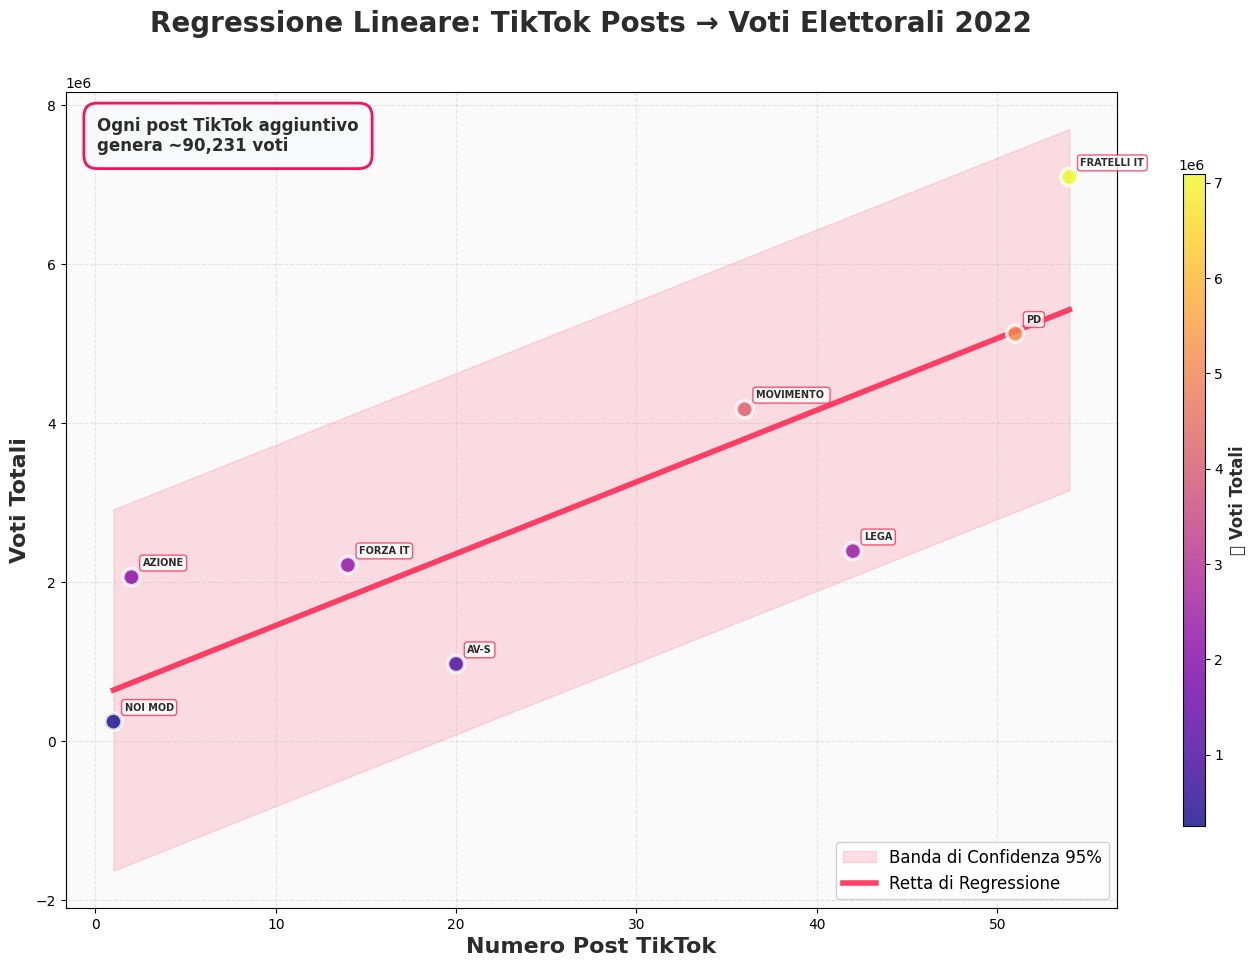

In [12]:
# 📱 REGRESSIONE ELEGANTE: NUMERO POST TIKTOK → VOTI ELETTORALI


# Configurazione colori eleganti
COLORS = {
    'primary': '#FF0050',   
    'secondary': '#25F4EE',  
    'accent': '#FE2C55',     
    'dark': '#2C2C2C',
    'light': '#F8F9FA',
    'gradient': ['#FF0050', '#25F4EE', '#FE2C55']
}

# === PREPARAZIONE DATI ===
valid_data = merged_data[(merged_data['NUMERO_POST_TIKTOK'] > 0) & (merged_data['TOTALE_VOTI_LISTA'] > 0)]

X = valid_data['NUMERO_POST_TIKTOK'].values.reshape(-1, 1)
y = valid_data['TOTALE_VOTI_LISTA'].values

# Addestra modello
model = LinearRegression()
model.fit(X, y)

# Metriche
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
corr, p_value = pearsonr(valid_data['NUMERO_POST_TIKTOK'], valid_data['TOTALE_VOTI_LISTA'])

# === GRAFICO ELEGANTE ===
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
fig.patch.set_facecolor('white')

# Scatter plot con gradiente di colori basato sui voti
scatter = ax.scatter(valid_data['NUMERO_POST_TIKTOK'], 
                    valid_data['TOTALE_VOTI_LISTA'],
                    c=valid_data['TOTALE_VOTI_LISTA'],
                    s=150, 
                    cmap='plasma',
                    alpha=0.8,
                    edgecolors='white', 
                    linewidth=2.5,
                    zorder=3)

# Retta di regressione elegante
x_range = np.linspace(valid_data['NUMERO_POST_TIKTOK'].min(), 
                      valid_data['NUMERO_POST_TIKTOK'].max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))

# Banda di confidenza (simulata)
residuals = y - y_pred
std_residuals = np.std(residuals)
confidence_band = 1.96 * std_residuals

ax.fill_between(x_range, 
                y_range - confidence_band, 
                y_range + confidence_band,
                alpha=0.15, 
                color=COLORS['accent'],
                label='Banda di Confidenza 95%',
                zorder=1)

# Retta di regressione principale
ax.plot(x_range, y_range, 
        color=COLORS['accent'], 
        linewidth=4, 
        alpha=0.9,
        label=f'Retta di Regressione',
        zorder=2)

# Annotazioni partiti eleganti
acronimi_partiti = {
    'FRATELLI D\'ITALIA': 'FRATELLI IT',
    'PARTITO DEMOCRATICO': 'PD',
    'LEGA': 'LEGA',
    'FORZA ITALIA': 'FORZA IT',
    'AZIONE': 'AZIONE',
    'ALLEANZA VERDI E SINISTRA': 'AV-S',
    'NOI MODERATI': 'NOI MOD',
    # Aggiungi altri se servono
}
for _, row in valid_data.iterrows():
    ax.annotate(acronimi_partiti.get(row['PARTITO'], row['PARTITO'][:10]), 
               (row['NUMERO_POST_TIKTOK'], row['TOTALE_VOTI_LISTA']),
               xytext=(8, 8), 
               textcoords='offset points',
               fontsize=7, 
               fontweight='600',
               color=COLORS['dark'],
               bbox=dict(boxstyle='round,pad=0.3', 
                        facecolor='white', 
                        edgecolor=COLORS['accent'],
                        alpha=0.8),
               zorder=4)

# Styling elegante
ax.set_xlabel('Numero Post TikTok', fontweight='bold', fontsize=16, color=COLORS['dark'])
ax.set_ylabel('Voti Totali', fontweight='bold', fontsize=16, color=COLORS['dark'])

# Titolo con statistiche
title = f'Regressione Lineare: TikTok Posts → Voti Elettorali 2022\n'
ax.set_title(title, fontsize=20, fontweight='bold', color=COLORS['dark'], pad=20)

# Grid elegante
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_facecolor('#FAFAFA')

# Equazione matematica stilizzata
textstr = f'Ogni post TikTok aggiuntivo\ngenera ~{model.coef_[0]:,.0f} voti'

props = dict(boxstyle='round,pad=0.8', 
             facecolor=COLORS['light'], 
             edgecolor=COLORS['primary'],
             linewidth=2,
             alpha=0.95)

ax.text(0.03, 0.97, textstr, transform=ax.transAxes, 
        fontsize=12, fontweight='bold',
        verticalalignment='top',
        bbox=props,
        color=COLORS['dark'])

# Colorbar elegante
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=30)
cbar.set_label('🗳️ Voti Totali', fontweight='bold', fontsize=12, color=COLORS['dark'])
cbar.ax.tick_params(labelsize=10)

# Legenda
ax.legend(loc='lower right', fontsize=12, framealpha=0.9)

# Layout finale
plt.tight_layout()
plt.subplots_adjust(top=0.88)

plt.show()

<div style="display: flex; justify-content: center; font-family: Arial, sans-serif; color: #000; max-width: 1100px; margin: 40px auto;">
  <div style="flex: 1 1 500px; min-width: 300px; background:#FAFAFA; padding:20px; border-radius:12px; box-shadow:0 4px 10px rgba(0,0,0,0.08);">
    <h2 style="text-align:center; color:#2C2C2C;">Metriche Principali del Modello</h2>
    <table style="width:100%; border-collapse:collapse; font-size:16px; margin-top:20px;">
      <thead>
        <tr style="background:#F0F0F0;">
          <th style="padding:10px; text-align:left;">Metrica</th>
          <th style="padding:10px; text-align:right;">Valore</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td style="padding:10px;">R² (Varianza spiegata)</td>
          <td style="padding:10px; text-align:right;">0.703 → 70.3%</td>
        </tr>
        <tr>
          <td style="padding:10px;">MAE (Errore Medio Assoluto)</td>
          <td style="padding:10px; text-align:right;">941,922 voti (31.0%)</td>
        </tr>
        <tr>
          <td style="padding:10px;">RMSE (Errore Quadratico Medio)</td>
          <td style="padding:10px; text-align:right;">1,158,744 voti (38.2%)</td>
        </tr>
      </tbody>
    </table>
    <p style="margin-top:20px; font-size:12px; text-align:center; color:gray;">
      <i>Valutazione delle prestazioni del modello di regressione lineare</i><br>
    </p>
  </div>
</div>

<h2 style="text-align:center; color:#2C2C2C;">Metriche Principali del Modello</h2>
<div style="display: flex; justify-content: center; font-family: Arial, sans-serif; color: #000; margin-top: 20px;">
  <div style="flex: 1 1 400px; min-width: 300px; background: #FAFAFA; padding: 20px; border-radius: 12px; box-shadow: 0 4px 10px rgba(0,0,0,0.08);">
    <h3 style="margin-top: 0; color:#2C2C2C;">Quanto è affidabile il modello?</h3>
    <ul style="padding-left: 20px; line-height: 1.6;">
      <li>Spiega circa <strong>70% della varianza</strong> nei voti totali</li>
      <li>Errore medio assoluto di <strong>~941k voti</strong></li>
      <li>RMSE più alto (1.1M) penalizza gli errori maggiori</li>
    </ul>
    <p style="margin-top: 10px;"><b>Conclusione:</b> modello buono. Adatto a stime generali, meno a previsioni precise per partiti minori.</p>
      <p style="margin-top:20px; font-size:12px; text-align:center; color:gray;">
      <i>Valutazione delle prestazioni del modello di regressione lineare</i><br>
    </p>
  </div>
</div>

<div style="max-width: 900px; margin: 40px auto; background: #FAFAFA; padding: 25px 30px; border-radius: 12px; box-shadow: 0 4px 10px rgba(0,0,0,0.08); font-family: Arial, sans-serif; color: #000;">
  <h2 style="text-align: center; color: #2C2C2C;"><b>Conclusioni</b></h2>
  <h3 style="text-align: center; color: #666;">Cosa abbiamo scoperto dalle analisi?</h3>
  <ol style="font-size: 16px; line-height: 1.8; padding-left: 20px; margin-top: 20px;">
    <li><b>Come si distribuiscono le metriche TikTok durante le elezioni politiche italiane?</b>
      <ul style="list-style-type: disc; padding-left: 20px;">
        <li>Le variabili mostrano <strong>distribuzioni asimmetriche e non gaussiane</strong>, con forte skew positivo.</li>
        <li>L’engagement è molto concentrato su pochi partiti: effetto “superstar”.</li>
      </ul>
    </li>
    <li><b>Chi sono i Top Performer su TikTok tra i politici?</b>
      <ul style="list-style-type: disc; padding-left: 20px;">
        <li>I partiti con maggiore visibilità e interazioni sono anche quelli con risultati elettorali migliori</li>
        <li>FDI e FI dominano rispettivamente per post e views.</li>
      </ul>
    </li>
    <li><b>Quale metrica TikTok è più predittiva dei voti reali?</b>
      <ul style="list-style-type: disc; padding-left: 20px;">
        <li>Il <strong>numero di post pubblicati</strong> è il miglior predittore, seguito dalle views totali.</li>
        <li>La correlazione è confermata da test Pearson, Spearman e Kendall.</li>
      </ul>
    </li>
    <li><b>È possibile prevedere in anticipo il risultato elettorale usando TikTok?</b>
      <ul style="list-style-type: disc; padding-left: 20px;">
        <li>Sì. Il modello lineare spiega <strong>oltre il 70% della varianza</strong> nei voti.</li>
        <li>La previsione è accettabile nonostante il basso numero di campioni.</li>
      </ul>
    </li>
  </ol>
  <p style="margin-top: 25px; text-align: center; font-size: 12px; color: gray;">
    <i>Data Science Project - Mehdi Zahid - UNIUD 2025</i>
  </p>
</div>